In [1]:
#@title Importing libraries (double-click to show code)
import os
import pkg_resources
pkg_resources.require("numpy>=`1.20.1")  #  to use specific numpy version
import numpy as np
import rsnapsim as rss
import sys
from sys import platform
from skimage import io ; from skimage.io import imread; from skimage.measure import find_contours
from random import randrange
import pandas as pd
import os; from os import listdir; from os.path import isfile, join
import re
import shutil
import pathlib
from pathlib import Path
from random import randrange
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout 
from IPython.display import Image
import dna_features_viewer
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord, CircularGraphicRecord
import tqdm.notebook as tq

# Defining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')

masks_dir = current_dir.parents[1].joinpath('DataBases','masks_for_sim_cell')

# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp
import matplotlib

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = False


In [2]:
# Plasmid sequences
gene_file_pUB_SM_KDM5B_PP7 = str(sequences_dir.joinpath('pUB_SM_KDM5B_PP7.gb')) # plasmid pUB_SM_KDM5B_PP7 
gene_file_pUB_SM_p300_MS2 = str(sequences_dir.joinpath('pUB_SM_p300_MS2.gb')) # plasmid pUB_SM_p300_MS2

# Coding sequence
gene_file_KDM5B_PP7 = str(sequences_dir.joinpath('pUB_SM_KDM5B_PP7_coding_sequence.txt')) # coding sequence for SM_KDM5B_PP7    ### 5685 nt   ### 1895 codons
gene_file_p300_MS2 = str(sequences_dir.joinpath('pUB_SM_p300_MS2_coding_sequence.txt'))  # coding sequence for SM_p300_MS2      ### 8268 nt   ### 2756 codons

In [3]:
from dna_features_viewer import BiopythonTranslator
class MyCustomTranslator(BiopythonTranslator):
    """Custom translator
    """
    def compute_feature_color(self, feature):
        if feature.type == "CDS":
            return "#57B956"
        elif feature.type == "FLAG":
            return "#57B956"
        elif feature.type == "MS2":
            return "#098BF5"
        elif feature.type == "PP7": 
            return "#EB5559"
        else:
            return "#C4B07B"

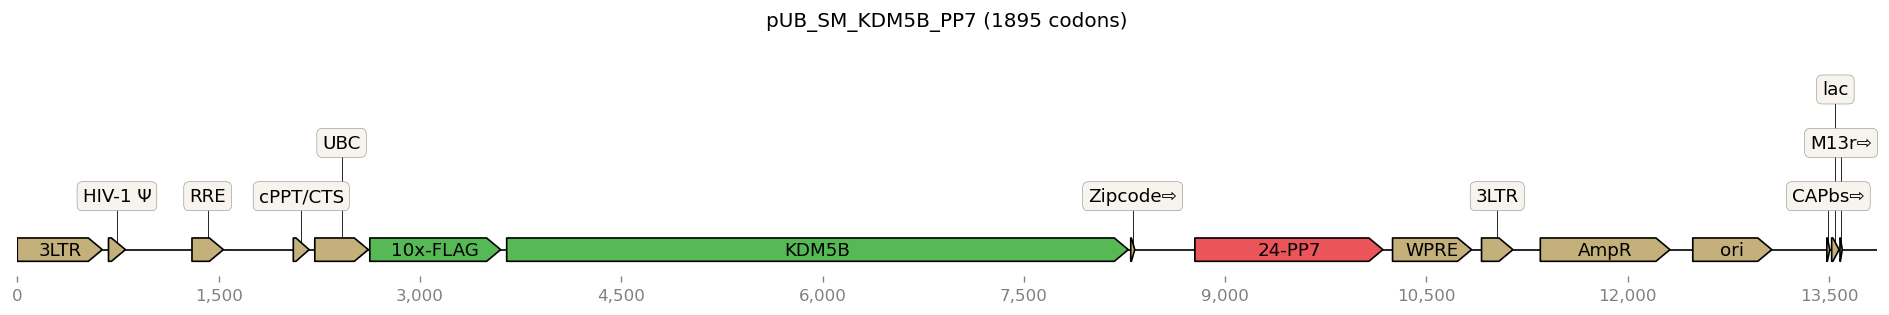

In [4]:
graphic_record = MyCustomTranslator().translate_record(gene_file_pUB_SM_KDM5B_PP7) 
ax, _ = graphic_record.plot(figure_width=20, strand_in_label_threshold=7)
ax.set_title('pUB_SM_KDM5B_PP7 (1895 codons)')
graphic_record.plot_legend(ax=ax, loc=1, ncol=3, frameon=False)
#ax.figure.savefig("pUB_SM_KDM5B_PP7.png")

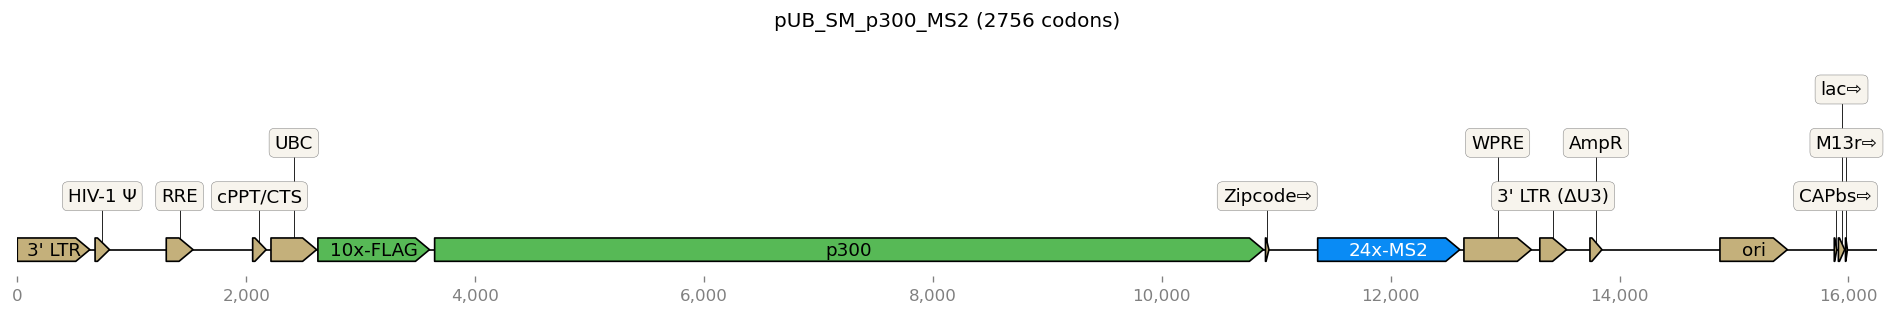

In [5]:
graphic_record = MyCustomTranslator().translate_record(gene_file_pUB_SM_p300_MS2) 
ax, _ = graphic_record.plot(figure_width=20, strand_in_label_threshold=7)
ax.set_title('pUB_SM_p300_MS2 (2756 codons)')
graphic_record.plot_legend(ax=ax, loc=1, ncol=3, frameon=False)
#ax.figure.savefig("pUB_SM_p300_MS2.png")

In [6]:
# Constant Parameters
list_gene_sequences = [gene_file_KDM5B_PP7, gene_file_p300_MS2] # path to gene sequences
#list_label_names = ['kdm5b','p300'] # list of strings used to generate a classification field in the output data frame
list_label_names = [0,1] # list of strings used to generate a classification field in the output data frame

step_size_in_sec = 1 # step size
save_as_tif = 0 # option to save the simulated video
save_dataframe = 0 # option to save the simulation output as a dataframe in format csv. 
create_temp_folder = 0 # saves the video and data frame in a temp folder
spot_size = 7 # size of spots in pixels
list_number_spots = [25, 25] # list of integers, where each element represents the number of spots
number_cells = 2 # Number of simulated Cell
list_target_channels_proteins = [1, 1] # channel where the simulated protein spots will be located. Integer between 0 and 2. 
list_target_channels_mRNA = [0, 2] # channel where the simulated mRNA spots will be located. Integer between 0 and 2. 
simulation_time_in_sec = 300

simulated_RNA_intensities_method = 'random_values'

In [7]:
# Parameters that affect the simulation dynamics.
#frame_selection_empty_video = 'constant' # Options are: 'constant' , 'shuffle' and 'loop'
#list_diffusion_coefficients =[0.55, 0.55] # diffusion coefficients for each gene
#list_elongation_rates = [10, 10] # elongation rates aa/sec
#list_initiation_rates = [0.03, 0.03] # initiation rates 1/sec

In [8]:
intensity_scale_ch0 = 400
intensity_scale_ch1 = 100
intensity_scale_ch2 = 400

In [9]:
# Path to store data
#multiplexing_path_folder = Path('/','home','luisub','Dropbox','multiplexing')   # Dropbox Linux
current_folder = pathlib.Path().absolute()
multiplexing_path_folder = current_folder.joinpath('temp')
if not os.path.exists(str(multiplexing_path_folder)):
    os.makedirs(str(multiplexing_path_folder))

print(multiplexing_path_folder)
#multiplexing_path_folder = Path('/','Users','luisaguilera','Dropbox','multiplexing')  # Dropbox Mac
#multiplexing_path_folder = Path('/','Users','luisaguilera','Desktop','testing')

/home/luisub/Desktop/rsnaped/notebooks/Machine_Learning/temp


In [10]:
def simulate_multiplexing(video_dir,masks_dir,tested_list_elongation_rates,tested_list_initiation_rates,tested_list_diffusion_coefficients,multiplexing_path_folder,frame_selection_empty_video,simulated_RNA_intensities_method):
    # function  that simulates the multiplexing experiments    
    list_dataframe_simulated_cell =[]
    list_ssa_all_cells_and_genes =[]
    
    list_videos = []
    
    # Reading all empty cells in directory
    list_files_names = sorted([f for f in listdir(video_dir) if isfile(join(video_dir, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
    list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
    path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
    num_cell_shapes = len(path_files)
    
    
    for i in range(0,number_cells): # for i in range (0,number_cells ):
        saved_file_name = 'cell_' + str(i)  # if the video or dataframe are save, this variable assigns the name to the files
        sel_shape = randrange(num_cell_shapes)
        video_path = path_files[sel_shape]
        initial_video = io.imread(video_path) # video with empty cell
        mask_image = imread(masks_dir.joinpath('mask_cell_shape_'+str(sel_shape)+'.tif'))
        # This step reduces the intensity of the empty video by a half. This is necessary to match the intensity in a video with spots. Check code "Analysis_simulated_cells.ipynb"
        video, single_dataframe_simulated_cell, list_ssa = rsp.SimulatedCellMultiplexing(initial_video,
                                                                                    list_gene_sequences,
                                                                                    list_number_spots,
                                                                                    list_target_channels_proteins,
                                                                                    list_target_channels_mRNA, 
                                                                                    tested_list_diffusion_coefficients,
                                                                                    list_label_names,
                                                                                    tested_list_elongation_rates,
                                                                                    tested_list_initiation_rates,
                                                                                    simulation_time_in_sec,
                                                                                    step_size_in_sec,
                                                                                    save_as_tif, 
                                                                                    save_dataframe, 
                                                                                    saved_file_name,
                                                                                    create_temp_folder,
                                                                                    mask_image=mask_image,
                                                                                    cell_number =i,
                                                                                    frame_selection_empty_video=frame_selection_empty_video,
                                                                                    spot_size =spot_size ,
                                                                                    intensity_scale_ch0 = intensity_scale_ch0,
                                                                                    intensity_scale_ch1 = intensity_scale_ch1,
                                                                                    intensity_scale_ch2 = intensity_scale_ch2,
                                                                                    dataframe_format='long',
                                                                                    simulated_RNA_intensities_method=simulated_RNA_intensities_method).make_simulation()
        # appending dataframes for each cell
        list_dataframe_simulated_cell.append(single_dataframe_simulated_cell)
        list_ssa_all_cells_and_genes.append(list_ssa)
        list_videos.append(video)
    # Creating a folder
    folder_to_save_data = 'multiplexing_data__bg_' + frame_selection_empty_video + '__ke_' + str(tested_list_elongation_rates[0])+'_'+str(tested_list_elongation_rates[1])+'__ki_'+str(tested_list_initiation_rates[0])[2:]+'_'+str(tested_list_initiation_rates[1])[2:]+'__kdiff_'+str(tested_list_diffusion_coefficients[0])+'_'+str(tested_list_diffusion_coefficients[1])  + '__time_' + str(simulation_time_in_sec) + '__cells_' + str(number_cells) +'__spots_' +str(list_number_spots[0])+ '_' +str(list_number_spots[1]) +'__int_scale_ch0_' +str(intensity_scale_ch0)+'__int_scale_ch1_' +str(intensity_scale_ch1)+'__int_scale_ch2_' +str(intensity_scale_ch2)
    folder_to_save_data = folder_to_save_data.replace(".", "_")
    multiplexing_path = multiplexing_path_folder.joinpath(folder_to_save_data)
    dataframe_simulated_cell = pd.concat(list_dataframe_simulated_cell)
    ssas_multiplexing = np.array(list_ssa_all_cells_and_genes)
    return list_videos, multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing

In [11]:
def save_data (multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing):
    security_testing = multiplexing_path.parents[0].exists()
    # testing if the parent path exist
    if security_testing == True:
        if not multiplexing_path.exists():
            #multiplexing_path.mkdir()
            os.makedirs(multiplexing_path)
        else:
            shutil.rmtree(multiplexing_path)
            #multiplexing_path.mkdir()
            os.makedirs(multiplexing_path)
        # saving the dataframe
        dataframe_simulated_cell.to_csv( multiplexing_path.joinpath('multiplexing_csv.csv'), float_format="%.2f")
        # saving the ssa
        np.save(multiplexing_path.joinpath('ssas_multiplexing.npy') , ssas_multiplexing)
        # creating zip
        shutil.make_archive(multiplexing_path, 'zip', multiplexing_path.parents[0],folder_to_save_data)
        shutil.rmtree(multiplexing_path)
    else:
        print ('The folder does not exist')

In [12]:
frame_selection_empty_video = 'generate_from_gaussian' # Options are: 'constant' , 'shuffle' and 'loop' 'generate_from_gaussian'
# Simulation_0
list_diffusion_coefficients =[3, 3] # diffusion coefficients for each gene
list_elongation_rates = [5.33, 5.33] # elongation rates aa/sec
list_initiation_rates = [0.08, 0.08] # initiation rates 1/sec
list_videos, multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing = simulate_multiplexing( video_dir,
                                                                                                            masks_dir,
                                                                                                            list_elongation_rates,
                                                                                                            list_initiation_rates,
                                                                                                            list_diffusion_coefficients,
                                                                                                            multiplexing_path_folder,
                                                                                                            frame_selection_empty_video,
                                                                                                            simulated_RNA_intensities_method)

#dataframe_simulated_cell = reduce_dataframe(dataframe_simulated_cell)
#save_data (multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing)

#del multiplexing_path,folder_to_save_data, dataframe_simulated_cell,dataframe_simulated_cell_complete, ssas_multiplexing

In [13]:
dataframe_simulated_cell.head()

,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,...,SNR_red,SNR_green,SNR_blue,background_int_mean_red,background_int_mean_green,background_int_mean_blue,background_int_std_red,background_int_std_green,background_int_std_blue,Classification
0,0,0,0,1055.10,1181.94,-32.72,591.92,835.41,440.19,133,...,9.62,1.85,-0.05,1626.96,6390.93,6358.23,110.15,628.99,621.07,0
1,0,0,1,956.33,1087.35,-41.96,525.78,771.64,493.40,132,...,8.34,1.83,-0.13,1600.71,6167.62,6105.56,113.18,598.33,535.78,0
2,0,0,2,1366.92,1132.88,16.34,763.70,698.94,455.71,128,...,15.08,2.01,0.05,1534.20,5705.19,5766.29,90.89,546.64,552.96,0
3,0,0,3,310.15,1083.19,-16.87,204.70,829.78,425.15,127,...,3.10,1.73,0.09,1514.87,5604.77,5581.28,100.23,578.69,508.21,0
4,0,0,4,391.35,1004.67,33.42,227.56,758.93,453.69,124,...,3.26,1.65,-0.03,1588.01,6083.12,6011.13,124.10,619.01,650.54,0


In [14]:
# Loading the simulated video
selected_cell =0
simulated_video = list_videos[selected_cell]

Dimensions in the simulated video:  (300, 512, 512, 3)


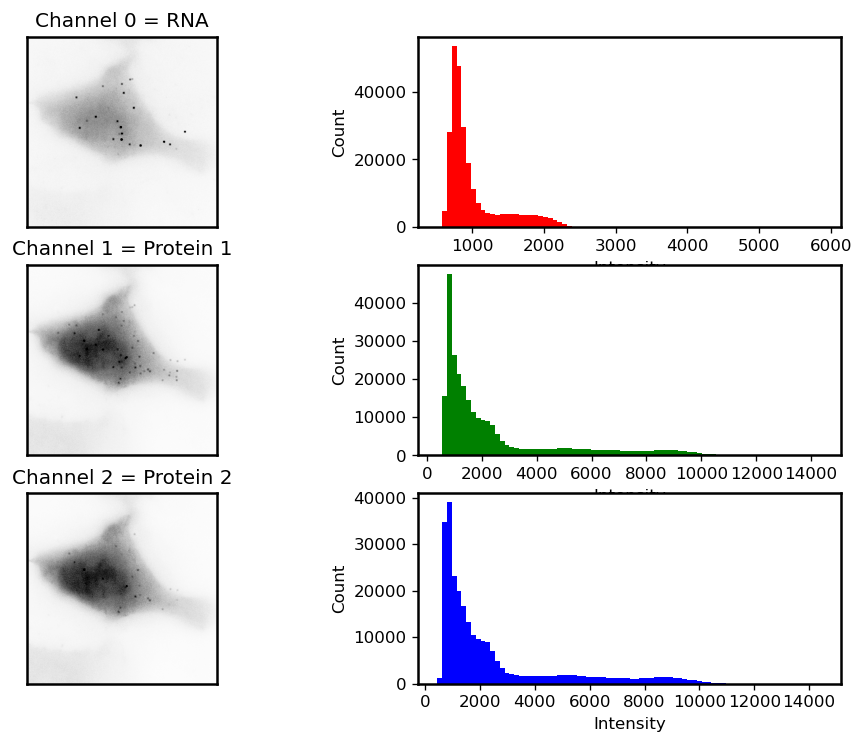

In [15]:
#@title Plotting the simulated cells
selected_time_point = 1
max_percentile=99.95
print('Dimensions in the simulated video: ', simulated_video.shape)
fig, ax = plt.subplots(3,2, figsize=(10, 7))
int_red = simulated_video[selected_time_point,:,:,0]
int_green = simulated_video[selected_time_point,:,:,1]
int_blue = simulated_video[selected_time_point,:,:,2]

# Red
ax[0,0].imshow(int_red,cmap=plt.cm.Greys,vmax=np.percentile(int_red,max_percentile))
ax[0,0].set_title('Channel 0 = RNA');ax[0,0].set_xticks([]); ax[0,0].set_yticks([])
ax[0,1].hist(int_red.flatten(), bins=80,color='red')
ax[0,1].set_xlabel('Intensity'); ax[0,1].set_ylabel('Count')

# Green
ax[1,0].imshow(int_green,cmap=plt.cm.Greys,vmax=np.percentile(int_green,max_percentile))
ax[1,0].set_title('Channel 1 = Protein 1'); ax[1,0].set_xticks([]); ax[1,0].set_yticks([])
ax[1,1].hist(int_green.flatten(), bins=80,color='green')
ax[1,1].set_xlabel('Intensity'); ax[1,1].set_ylabel('Count')

# Blue
ax[2,0].imshow(int_blue,cmap=plt.cm.Greys,vmax=np.percentile(int_blue,max_percentile))
ax[2,0].set_title('Channel 2 = Protein 2'); ax[2,0].set_xticks([]); ax[2,0].set_yticks([])
ax[2,1].hist(int_blue.flatten(), bins=80,color='blue')
ax[2,1].set_xlabel('Intensity'); ax[2,1].set_ylabel('Count')
plt.show()

In [16]:
df = dataframe_simulated_cell
SNR_red_channel = df.loc[(df['cell_number']==selected_cell) ].SNR_red.values
SNR_green_channel = df.loc[(df['cell_number']==selected_cell) ].SNR_green.values
SNR_blue_channel = df.loc[(df['cell_number']==selected_cell) ].SNR_blue.values

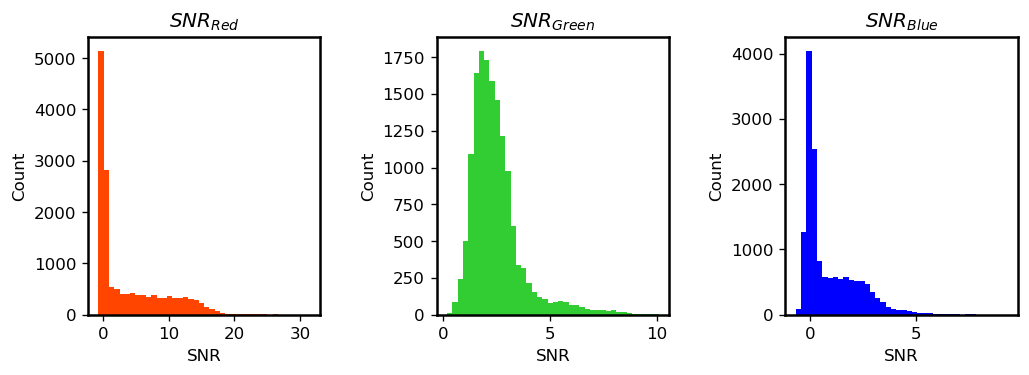

In [17]:
#@title ####Plotting SNR

# Plotting
fig, ax = plt.subplots(1,3, figsize=(10, 3))
ax[0].hist(SNR_red_channel, bins = 40, color = 'orangered')
ax[0].set_ylabel('Count')
ax[0].set_title('$SNR_{Red}$')
ax[0].set_xlabel('SNR')

ax[1].hist(SNR_green_channel, bins = 40, color = 'limegreen')
ax[1].set_ylabel('Count')
ax[1].set_title('$SNR_{Green}$')
ax[1].set_xlabel('SNR')

ax[2].hist(SNR_blue_channel, bins = 40, color = 'blue')
ax[2].set_ylabel('Count')
ax[2].set_title('$SNR_{Blue}$')
ax[2].set_xlabel('SNR')
plt.subplots_adjust(wspace=0.5, hspace=0)

plt.show()

In [18]:
raise

RuntimeError: No active exception to reraise

In [ ]:
frame_selection_empty_video = 'shuffle' # Options are: 'constant' , 'shuffle' and 'loop'
# Simulation_1
list_diffusion_coefficients =[3, 3] # diffusion coefficients for each gene
list_elongation_rates = [10, 10] # elongation rates aa/sec
list_initiation_rates = [0.03, 0.03] # initiation rates 1/sec
multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing = simulate_multiplexing(list_elongation_rates,list_initiation_rates,list_diffusion_coefficients,multiplexing_path_folder)
save_data (multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing)
del multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing

In [ ]:
raise

In [ ]:
# Simulation_2
list_diffusion_coefficients =[0.5, 0.5] # diffusion coefficients for each gene
list_elongation_rates = [10, 10] # elongation rates aa/sec
list_initiation_rates = [0.05, 0.03] # initiation rates 1/sec
multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing = simulate_multiplexing(list_elongation_rates,list_initiation_rates,list_diffusion_coefficients,multiplexing_path_folder)
save_data (multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing)
multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing

In [ ]:
# Simulation_3
list_diffusion_coefficients =[0.9, 0.2] # diffusion coefficients for each gene
list_elongation_rates = [10, 10] # elongation rates aa/sec
list_initiation_rates = [0.03, 0.03] # initiation rates 1/sec
multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing = simulate_multiplexing(list_elongation_rates,list_initiation_rates,list_diffusion_coefficients,multiplexing_path_folder)
save_data (multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing)
multiplexing_path,folder_to_save_data, dataframe_simulated_cell, ssas_multiplexing